In [1]:
import pandas as pd
import numpy as np
from statistics import mean
import os
import torch
import random

import time
from tqdm import tqdm

from collections import defaultdict
from typing import List, Tuple

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold, StratifiedKFold
from transformers import BertTokenizer, BertModel

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler, SequentialSampler
from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, precision_score, recall_score

from IPython.display import Markdown, display

def display_markdown(markdown_text: str):
    display(Markdown(markdown_text))


2025-01-21 11:59:21.775048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 11:59:21.775179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 11:59:22.049095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cuda.


In [4]:
df = pd.read_csv('/kaggle/input/tos-100/dataset.csv')
# Replace NaN values in the 'triggers' column with 0.0
has_nan_values = df['label'].isna().any()

if has_nan_values:
  print("There are NaN values in the column.")
else:
  print("There are no NaN values in the column.")
# df['label'] = df['label'].apply(lambda x: [0.0 if pd.isna(val) else val for val in x])
# Convert the 'label' column to float
df['label'] = df['label'].astype(float)
df.head()

There are no NaN values in the column.


,Unnamed: 0,A,CH,CR,J,LAW,LTD,PINC,TER,USE,document,document_ID,label,text,TER_targets,LTD_targets,A_targets,CH_targets,CR_targets
0,0,0,0,0,0,0,0,0,0,0,Mozilla,0,0.0,websites & communications terms of use,NaN,NaN,NaN,NaN,NaN
1,1,0,0,0,0,0,0,0,0,0,Mozilla,0,0.0,please read the terms of this entire document ...,NaN,NaN,NaN,NaN,NaN
2,2,0,0,0,0,0,0,0,0,1,Mozilla,0,1.0,by accessing or signing up to receive communic...,NaN,NaN,NaN,NaN,NaN
3,3,0,0,0,0,0,0,0,0,0,Mozilla,0,0.0,our websites include multiple domains such as ...,NaN,NaN,NaN,NaN,NaN
4,4,0,0,0,0,0,0,0,0,0,Mozilla,0,0.0,you may also recognize our websites by nicknam...,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(20417, 19)

In [6]:
print(df["text"][1])

please read the terms of this entire document -lrb- `` terms '' -rrb- carefully because it explains your rights and responsibilities when you visit any of mozilla 's websites -lrb- `` websites '' -rrb- , or related feeds , social media , newsletters , source code repositories , and emails -lrb- together with websites , these are collectively referred to as `` communications '' -rrb- .


## Importing KB data

In [5]:
# Assuming the TOS-100 dataset is in a CSV format with 'text' and 'label' columns
# df = pd.read_csv('TOS-100.csv')

# Load shared memory KB.txt, assuming each line in KB.txt is a legal rationale
with open('/kaggle/input/memory/KB.txt', 'r') as f:
    legal_rationales = f.readlines()

# Preprocess the legal rationales (remove any extra whitespace or newline characters)
legal_rationales = [rationale.strip() for rationale in legal_rationales]
legal_rationales
# Create a DataFrame with one column named 'sentence'
# kb = pd.DataFrame({'legal_rationales': legal_rationales})

# # Print the DataFrame (optional)
# print(kb)

['The jurisdiction clause stipulates what courts will have the competence to adjudicate disputes under the contract.',
 'Consumers must have the right to bring disputes in their place of residence.',
 'Stating that any judicial proceeding takes a residence away is clearly unfair.',
 'Stating that any judicial proceeding takes a residence in a different city is clearly unfair.',
 'Stating that any judicial proceeding takes a residence in a different country is clearly unfair.',
 'The choice of law clause specifies what law will govern the contract.',
 'The choice of law clause specifies what law will be applied in potential adjudication of a dispute arising under the contract.',
 "Defining the applicable law as the law of the consumer's country of residence is clearly fair.",
 "Not defining the applicable law as the law of the consumer's country of residence is potentially unfair.",
 'The limitation of liability clause stipulates that the duty to pay damages is limited or excluded, for 

In [6]:
from sklearn.model_selection import train_test_split

texts = df['text'].values
labels = df['label'].values

# Split the dataset into training (80%) and testing (20%) sets
train_texts_cv, test_texts, train_labels_cv, test_labels = train_test_split(
    texts, labels, test_size=0.1, random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_cv, train_labels_cv, test_size=0.1, random_state=42)
print("Train Shape:",train_texts.shape)
print("CV Train Shape:",train_texts_cv.shape)
print("Val Shape:",val_texts.shape)
print("Test Shape:",test_texts.shape)

Train Shape: (16537,)
CV Train Shape: (18375,)
Val Shape: (1838,)
Test Shape: (2042,)


In [34]:
import nltk
from collections import defaultdict

# Download the punkt tokenizer model (if not already downloaded)
# nltk.download('punkt')

# Tokenize the texts and count the number of tokens
token_counts = defaultdict(int)

for text in texts:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    #tokens = nltk.word_tokenize(text)
    num_tokens = len(tokens)
    token_counts[num_tokens] += 1

# Print the results
for num_tokens, count in sorted(token_counts.items()):
    print(f"Number of texts with {num_tokens} tokens: {count}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Number of texts with 8 tokens: 212
Number of texts with 9 tokens: 237
Number of texts with 10 tokens: 282
Number of texts with 11 tokens: 308
Number of texts with 12 tokens: 338
Number of texts with 13 tokens: 353
Number of texts with 14 tokens: 379
Number of texts with 15 tokens: 404
Number of texts with 16 tokens: 450
Number of texts with 17 tokens: 429
Number of texts with 18 tokens: 424
Number of texts with 19 tokens: 502
Number of texts with 20 tokens: 470
Number of texts with 21 tokens: 536
Number of texts with 22 tokens: 526
Number of texts with 23 tokens: 515
Number of texts with 24 tokens: 512
Number of texts with 25 tokens: 522
Number of texts with 26 tokens: 488
Number of texts with 27 tokens: 445
Number of texts with 28 tokens: 472
Number of texts with 29 tokens: 439
Number of texts with 30 tokens: 471
Number of texts with 31 tokens: 423
Number of texts with 3

## Difining Hyperparameters

In [8]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Define hyperparameters
MODEL_NAME = 'bert-base-uncased'
model_dir= 'model/'
num_classes = 2
num_epochs = 5
batch_size = 32
learning_rate = 3e-04 #1e-5
weight_decay=1e-4
mem_size = 40
mem_dim = 768
num_lstm_layers = 8
ffnn_hidden_size: int = 128
#input_dim = 768
n_splits = 5  # Number of cross-validation splits


In [9]:
# Function to ensure the directory exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

ensure_directory(model_dir)

In [10]:
def max_token(dialogues):
    max_tokens = 0
    second_max_tokens = 0
    num_dialogues_with_max_tokens = 0
    num_dialogues_with_second_max_tokens = 0

    for dialogue in dialogues:
#         for utterance_idx in range(len(dialogue)):
#             start_idx = max(0, utterance_idx - window_size + 1)
#             end_idx = min(utterance_idx + 1, len(dialogue))
#             window_text = ' [SEP] '.join(dialogue[start_idx:end_idx])
        encoded_tokens = tokenizer.encode(dialogue, add_special_tokens=True)
        num_tokens = len(encoded_tokens)

        if num_tokens > max_tokens:
            second_max_tokens = max_tokens
            max_tokens = num_tokens
            num_dialogues_with_second_max_tokens = num_dialogues_with_max_tokens
            num_dialogues_with_max_tokens = 1
        elif num_tokens == max_tokens:
            num_dialogues_with_max_tokens += 1
        elif num_tokens > second_max_tokens:
            second_max_tokens = num_tokens
            num_dialogues_with_second_max_tokens = 1
        elif num_tokens == second_max_tokens:
            num_dialogues_with_second_max_tokens += 1

    return max_tokens, num_dialogues_with_max_tokens, second_max_tokens, num_dialogues_with_second_max_tokens

max_tokens, num_dialogues, second_max_tokens, num_dialogues_second = max_token(df['text'])

print(f"The maximum number of tokens in any text across the entire dataset is: {max_tokens}")
print(f"Number of text with the maximum tokens: {num_dialogues}")
print(f"The second maximum number of tokens: {second_max_tokens}")
print(f"Number of text with the second maximum tokens: {num_dialogues_second}")

The maximum number of tokens in any text across the entire dataset is: 491
Number of text with the maximum tokens: 1
The second maximum number of tokens: 441
Number of text with the second maximum tokens: 1


In [9]:
kb_max_length, num_dialogues,_,_ = max_token(legal_rationales)
print(f"The maximum number of tokens in any explaination across the entire kb is: {kb_max_length}")
print(f"Number of dialogues with the maximum tokens: {num_dialogues}")

The maximum number of tokens in any explaination across the entire kb is: 47
Number of dialogues with the maximum tokens: 1


In [11]:
class TokenizerDataset(Dataset):
    def __init__(self, texts, labels, max_length=200):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {'text': text,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.float)
        }


dataset = TokenizerDataset(texts, labels)
dataset[1]


{'text': "please read the terms of this entire document -lrb- `` terms '' -rrb- carefully because it explains your rights and responsibilities when you visit any of mozilla 's websites -lrb- `` websites '' -rrb- , or related feeds , social media , newsletters , source code repositories , and emails -lrb- together with websites , these are collectively referred to as `` communications '' -rrb- .",
 'input_ids': tensor([  101,  3531,  3191,  1996,  3408,  1997,  2023,  2972,  6254,  1011,
          1048, 15185,  1011,  1036,  1036,  3408,  1005,  1005,  1011, 25269,
          2497,  1011,  5362,  2138,  2009,  7607,  2115,  2916,  1998, 10198,
          2043,  2017,  3942,  2151,  1997,  9587,  5831,  4571,  1005,  1055,
         11744,  1011,  1048, 15185,  1011,  1036,  1036, 11744,  1005,  1005,
          1011, 25269,  2497,  1011,  1010,  2030,  3141, 14172,  1010,  2591,
          2865,  1010, 17178,  2015,  1010,  3120,  3642, 16360, 20049, 29469,
          2229,  1010,  1998, 2202

# Model NMNBert_1

<b>Knowledge Base Handler (KBHandler)</b>:

- <b>Purpose</b>: This module handles the knowledge base (KB) texts and prepares them for input into the model.

- <b>Components</b>:
     - <b>Sampling Knowledge Base Texts</b>: Randomly selects a subset of KB texts of size sample_size using the sample_kb_texts() method.

     - <b>Tokenization</b>: The selected texts are tokenized using the BERT tokenizer, which converts them into numerical representations (input_ids) and attention masks.

     - <b>Truncation and Padding</b>: Ensures that tokenized sequences are truncated or padded to a fixed maximum length (max_length=47), maintaining uniform input dimensions.

     - <b>Returning Encodings</b>: Prepares the tokenized KB encodings (input_ids and attention_mask) for further use by the model.

<b>Memory Module</b>:

- <b>Purpose</b>: Acts as a dynamic memory mechanism, storing, updating, and retrieving contextual knowledge to enhance predictions.
- <b>Components</b>:
   - <b>Memory Initialization</b>: Initializes the memory as a trainable parameter of size (memory_size, hidden_size). Each memory slot is represented as a vector.

   - <b>Attention Mechanism</b>: Utilizes a multi-head attention layer to compute attention scores between the memory and input embeddings.

   - <b>Read Operation</b>: Retrieves relevant information from the memory based on the computed attention weights.

   - <b>Update Mechanism</b>: Updates the memory using gating mechanisms:

       - <b>Write Gate</b>: Determines how much new information (e.g., KB embeddings) should be written to the memory.

       - <b>Forget Gate</b>: Controls which parts of the memory should be erased or forgotten.

   - <b>Normalization</b>: The memory is normalized to ensure stable updates and avoid exploding gradients.

- <b>NMNBert_1 Model</b>:

- <b>Purpose</b>: Combines the BERT architecture with a memory module to classify text into binary labels (fair/unfair).

- <b>Components</b>:
   - <b>BERT Encoder</b>: Pretrained bert-base-uncased model is used to generate embeddings from the input text. The last_hidden_state of BERT is averaged along the sequence dimension to produce a fixed-size input_embedding.

   - <b>KB Integration</b>: The KBHandler provides sampled KB texts, which are tokenized and encoded using BERT. KB embeddings are computed by averaging the last_hidden_state of these encodings.

   - <b>Memory Module</b>: The memory module is updated dynamically with both input embeddings and KB embeddings, enabling the model to adaptively incorporate external knowledge. Relevant memory slots are accessed via the read operation to create a read_vector.

   - <b>Feature Combination</b>: Combines the input_embedding and read_vector to form a richer representation of the input text.
   
   - <b>Feedforward Layer</b>: A linear layer (fc) maps the combined embeddings to the output size (binary classification). A Sigmoid activation function is applied to produce probabilities for the two classes (fair/unfair).

- <b>Model Workflow</b>:
Input Text → Tokenization → BERT Encoder → Input Embedding.

KBHandler → KB Sampling and Encoding → KB Embeddings.

- <b>Memory Module</b>:
    Update Memory with Input and KB Embeddings.

    Read Memory to Retrieve Contextual Features.

    Combine Input and Memory Features → Feedforward Layer → Output Classification.

In [12]:
class KBHandler:
    def __init__(self, kb_texts, sample_size, bert_model_name='bert-base-uncased'):
        self.kb_texts = kb_texts
        self.sample_size = sample_size
        self.tokenizer = tokenizer
        self.max_length = 47
    
    def sample_kb_texts(self):
        sampled_texts = random.sample(self.kb_texts, self.sample_size)
        sampled_texts = [text for text in sampled_texts]
        
        return sampled_texts
    
    def tokenize_sampled_texts(self, sampled_texts):

        encoding = self.tokenizer(
            sampled_texts,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
#         print(input_ids.shape)
        return {'text': sampled_texts,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
    
    def get_sampled_kb_encodings(self):
        sampled_texts = self.sample_kb_texts()
        encodings = self.tokenize_sampled_texts(sampled_texts)
        input_ids = encodings['input_ids'].to(device)
        mask = encodings['attention_mask'].to(device)

        return encodings['text'],input_ids, mask

class MemoryModule(nn.Module):
    def __init__(self, hidden_size, memory_size):
        super(MemoryModule, self).__init__()
        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.memory = nn.Parameter(torch.randn(memory_size, hidden_size))
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8)
        
        # Gating mechanisms
        self.write_gate = nn.Linear(hidden_size * 2, hidden_size)
        self.forget_gate = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(0.3)


    def read(self, input_embedding):
        input_embedding = input_embedding.unsqueeze(0)  # [1, batch_size, hidden_size]
        memory = self.memory.unsqueeze(1).expand(-1, input_embedding.size(1), -1)  # [memory_size, batch_size, hidden_size]
#         input_embedding = input_embedding.unsqueeze(0)  # [1, batch_size, hidden_size]
#         memory = self.memory.unsqueeze(1)  # [memory_size, 1, hidden_size]
        attn_output, attn_weights = self.attention(input_embedding, memory, memory)
        return attn_output.squeeze(0), attn_weights

    def update(self, input_embedding, kb_embeddings):
        self.memory = self.memory.to(device)
        for kb_embedding in kb_embeddings:
            # print("input_embedding shape:", input_embedding.shape)
            # print("kb_embeddings shape:", kb_embeddings.shape)
            kb_expanded = kb_embedding.unsqueeze(0).expand(input_embedding.size(0), -1)
            # print("kb_embeddings_expanded shape:", kb_expanded.shape)
            combined = torch.cat((input_embedding, kb_expanded), dim=1)

            # combined = torch.cat((input_embedding, kb_embedding.unsqueeze(0).expand(input_embedding.size(0), -1)), dim=1)
            # print("combined shape:", combined.shape)
            # combined = torch.cat((input_embedding, kb_embedding.unsqueeze(0).expand(input_embedding.size(0), -1)), dim=1)
            write_weights = torch.sigmoid(self.write_gate(combined))
            forget_weights = torch.sigmoid(self.forget_gate(combined))
            # print("write_weights shape:", write_weights.shape)
            # print("forget_weights shape:", forget_weights.shape)
            # Normalize updates
            normalized_memory = (self.memory * (1 - forget_weights.mean(dim=0))) + \
                                (write_weights.mean(dim=0) * kb_embedding)
            # self.memory = torch.nn.functional.normalize(normalized_memory, dim=-1)
            with torch.no_grad():
                self.memory.copy_(torch.nn.functional.normalize(normalized_memory, dim=-1))


class NMNBert_1(nn.Module):
    def __init__(self, kb_handler, bert_model_name='bert-base-uncased', memory_size=10, output_size=1):
        super(NMNBert_1, self).__init__()
        self.bert = bert_model
        self.hidden_size = self.bert.config.hidden_size
        
        self.kb_handler = kb_handler
        self.memory_module = MemoryModule(self.hidden_size, memory_size)
        
        self.fc = nn.Linear(self.hidden_size * 2, output_size)
        self.activation = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            input_outputs = self.bert(**{"input_ids": input_ids,
                                                  "attention_mask": attention_mask}).last_hidden_state
            input_embedding = input_outputs.mean(dim=1)

        # Sample and encode KB texts dynamically
        _,ids, mask = self.kb_handler.get_sampled_kb_encodings()
        kb_outputs = self.bert(**{"input_ids": ids,
                                                  "attention_mask": mask}).last_hidden_state
        kb_embeddings = kb_outputs.mean(dim=1)  # [sample_size, hidden_size]
        
        # Update memory with KB embeddings
        self.memory_module.update(input_embedding, kb_embeddings)

        # Read from memory
        read_vector, attn_weights = self.memory_module.read(input_embedding)

        # Combine input embedding and read vector
        combined = torch.cat((input_embedding, read_vector), dim=1)
        output = self.fc(combined)
        output = self.activation(output)
        
        return output, attn_weights


In [13]:
kb_d = KBHandler(legal_rationales, sample_size=10)

sampled_text, input_ids, mask = kb_d.get_sampled_kb_encodings()

# Print the sampled sentences
print("Sampled Sentences:")
print(sampled_text[9])

# Print the corresponding input IDs (optional)
print("\nSampled Input IDs:")
print(input_ids[9])

# Print the corresponding attention masks (optional)
print("\nSampled Attention Masks:")
print(mask[1])

Sampled Sentences:
The jurisdiction clause stipulates what courts will have the competence to adjudicate disputes under the contract.

Sampled Input IDs:
tensor([  101,  1996,  7360, 11075,  2358, 11514, 18969,  2054,  5434,  2097,
         2031,  1996, 22219,  2000,  4748,  9103, 16467, 11936,  2104,  1996,
         3206,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')

Sampled Attention Masks:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')


# Model NMNBert_2

<b>Workflow</b>:

- <b>Input Text</b>: Tokenized and encoded by BERT, producing the pooled_output.
- <b>Memory Reading</b>: The input embedding serves as a query for the memory module. Attention is computed between the query and memory slots to produce the read_vector.
- <b>Memory Writing</b>: The query embedding is updated with the LSTM's output (gated_lstm_out) and written back to memory. The write gate regulates how much new information updates the existing memory.
- <b>Combining Features</b>: The pooled_output from BERT is concatenated with the memory module's output.
- <b>Classification</b>: The combined features are passed through the classifier, which predicts the class label (fair or unfair).

In [27]:
import torch.nn.functional as F

class LSTMMemoryModule(nn.Module):
    def __init__(self, input_dim, mem_size, mem_dim,  kb):
        super(LSTMMemoryModule, self).__init__()
        self.mem_size = mem_size
        self.mem_dim = mem_dim
        self.input_dim = input_dim
        self.max_length = 47
        # Initialize memory with KB
        self.memory = nn.Parameter(self.load_kb(kb, mem_size, mem_dim))
        #print("M2")
        # LSTM for updating the memory
        self.lstm = nn.LSTM(input_dim + mem_dim, 
                            hidden_size=mem_dim,
                            num_layers=num_lstm_layers,
                            batch_first=True)
        # Layer normalization
        self.layer_norm = nn.LayerNorm(mem_dim)
        # Attention mechanism
        self.attention = nn.Linear(input_dim + mem_dim, 1)
        # Gates for read/write operations
        self.read_gate = nn.Linear(mem_dim, mem_dim)
        self.write_gate = nn.Linear(mem_dim, mem_dim)
   
    def load_kb(self, kb, mem_size, mem_dim):
        # Load KB.txt and convert to embeddings
        embeddings = []
        for line in kb:
            inputs = tokenizer(line, return_tensors='pt', truncation=True, max_length=self.max_length, padding='max_length')
            with torch.no_grad():
                outputs = bert_model(**inputs)
                embedding = outputs.last_hidden_state.mean(dim=1)  # Get the mean embedding
                embeddings.append(embedding.squeeze(0))
        
        # Padding memory if necessary
        while len(embeddings) < mem_size:
            embeddings.append(torch.zeros(mem_dim))
        
        memory = torch.stack(embeddings)
        return memory
    
    def read(self, query):
        # Expand query to match memory dimensions for concatenation"
        #print("query shape: ", query.shape)
        query_expanded = query.unsqueeze(1).repeat(1, self.mem_size, 1)  # [batch_size, mem_size, input_dim]
        #print("query shape after: ", query_expanded.shape)
        # Expand memory to match batch size
        #print("memory shape: ", self.memory.shape)
        memory_expanded = self.memory.unsqueeze(0).repeat(query.size(0), 1, 1)  # [batch_size, mem_size, mem_dim]
        #print("memory shape after: ", memory_expanded.shape)
        
        # Concatenate expanded query and memory
        combined_input = torch.cat((query_expanded, memory_expanded), dim=2)  # [batch_size, mem_size, input_dim + mem_dim]
        #print("combined shape: ", combined_input.shape)
        
        # Compute attention scores
        attention_scores = self.attention(combined_input).squeeze(-1)  # [batch_size, mem_size]
        #print("att scores shape: ", attention_scores.shape)
        
        # Compute attention weights using softmax
        attention_weights = nn.functional.softmax(attention_scores, dim=1)  # [batch_size, mem_size]
        #print("att weights shape: ", attention_weights.shape)
        
        # Compute read vector as the weighted sum of the memory
        read_vector = torch.bmm(attention_weights.unsqueeze(1), self.memory.unsqueeze(0).repeat(query.size(0), 1, 1)).squeeze(1)  # [batch_size, mem_dim]

        #print("read shape: ", read_vector.shape)
        return read_vector, attention_weights

    
    def write(self, query, write_vector):
        # Compute attention scores for write
        query_expanded = query.unsqueeze(1).repeat(1, self.mem_size, 1)
        memory_expanded = self.memory.unsqueeze(0).repeat(query.size(0), 1, 1)  # [batch_size, mem_size, mem_dim]
        combined_input = torch.cat((query_expanded, memory_expanded), dim=2)
        attention_scores = self.attention(combined_input).squeeze(-1)
        
        # Compute attention weights using softmax
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Apply the write gate
        gated_write_vector = torch.sigmoid(self.write_gate(write_vector))
        
        # Update the memory
        updated_memory = (1 - attention_weights.unsqueeze(-1)) * self.memory + attention_weights.unsqueeze(-1) * gated_write_vector.unsqueeze(1)
        
        # Update memory (mean aggregation over the batch dimension)
        for i in range(query.size(0)):
            # Calculate the weighted update
            update = attention_weights[i].unsqueeze(0).unsqueeze(-1) * gated_write_vector[i].unsqueeze(0)
            self.memory.data.copy_(self.memory.data * (1 - attention_weights[i].unsqueeze(-1)) + update.squeeze(0))

    
    def forward(self, query):
        # Read from memory
        read_vector, attention_weights = self.read(query)
        
        # Concatenate read vector with query
        lstm_input = torch.cat([query, read_vector], dim=-1).unsqueeze(1)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(lstm_input)
        lstm_out = lstm_out.squeeze(1)
        
        # Apply the read gate to the LSTM output
        gated_lstm_out = torch.sigmoid(self.read_gate(lstm_out))
        
        # Update memory with the output of the LSTM
        self.write(query, gated_lstm_out)
        
        return gated_lstm_out


In [28]:
class NMNBert_2(nn.Module):
    def __init__(self, bert_model, num_classes, ffnn_hidden_size: int, random_state = 42):
        super(NMNBert_2, self).__init__()
        #self.bert_model = bert_model
        #print("B1")
        self.bert_model = BertModel.from_pretrained(MODEL_NAME)
        
        if random_state is not None:
            torch.manual_seed(random_state)
            torch.cuda.manual_seed_all(random_state)
        #print("B2")
        self.memory_module = LSTMMemoryModule(self.bert_model.config.hidden_size, mem_size, mem_dim, legal_rationales)
        #print("B3")
        #self.classifier = nn.Linear(768 + memory_module.mem_dim, num_classes)  # Combine clause and memory embeddings
        self.classifier = nn.Sequential(
            nn.Linear(self.bert_model.config.hidden_size + self.memory_module.mem_dim, ffnn_hidden_size),
            nn.ReLU(),
            nn.Linear(ffnn_hidden_size, 1),
            nn.Sigmoid()
        )
        #print("B4")

    def forward(self, input_ids, attention_mask):

        with torch.no_grad():
            text_outputs = self.bert_model(**{"input_ids": input_ids,
                                              "attention_mask": attention_mask})
            #clause_embeddings = text_outputs.hidden_states[-1].mean(dim=1)  # Size: batch_size x hidden_dim
            pooled_output = text_outputs[1] 
            
        # Use clause embeddings as query for memory module
        memory_output = self.memory_module(pooled_output)  # Size: batch_size x mem_dim

        # Combine clause embeddings with memory output
        combined_embeddings = torch.cat((pooled_output, memory_output), dim=1)  # Size: batch_size x (hidden_dim + mem_dim)

        # Pass through classifier
        logits = self.classifier(combined_embeddings)  # Size: batch_size x num_classes

        return logits

## Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience: int = 1, min_delta: int = 0) -> None:
        self.patience = patience
        self.min_delta = min_delta
        self.min_validation_loss = float("inf")
        self.__epochs_no_improve = 0

    def early_stop(self, validation_loss: float) -> Tuple[bool, bool]:
        new_best_loss: bool = validation_loss < self.min_validation_loss
        if new_best_loss:
            self.min_validation_loss = validation_loss
            self.__epochs_no_improve = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.__epochs_no_improve += 1
            if self.__epochs_no_improve >= self.patience:
                return True, new_best_loss
        return False, new_best_loss

## Training and Evaluation

In [15]:

def evaluate_model(model, val_loader, criterion):
    # Validation loop
    model.eval()
    total_val_loss: float = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            output_probs,_ = model(input_ids, attention_mask)
            
            val_loss = criterion(output_probs.view(-1), labels)
            total_val_loss += val_loss.item()
            
            # output_probs = torch.sigmoid(logits)
            #_, predicted = torch.max(outputs, 1)
            val_preds.extend((output_probs > .5).int().cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        f1_weighted = f1_score(val_labels, val_preds, average='weighted')
        f1_macro = f1_score(val_labels, val_preds, average='macro')

        metrics = {"weighted_f1": round(f1_weighted,2),
                   "macro_f1": round(f1_macro,2)}

    return avg_val_loss, metrics

def train_and_evaluate(mdir,model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=3, cv = 'True', accumulation_steps: int = 4):

    model.to(device)

    # Training loop
    early_stopper = EarlyStopper(patience=2, min_delta=1e-2)

    best_val_loss = float('inf')
    best_model_state_dict = None

    for epoch in tqdm(range(num_epochs)):
        # print("1")
        model.train()
        optimizer.zero_grad()
        start_time = time.time()
        total_train_loss: float = 0.0
        for count, batch in enumerate(train_loader):
            #print("Count: ", count)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs,_ = model(input_ids, attention_mask)
            loss = criterion(outputs.view(-1), labels)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
            
            loss = loss / accumulation_steps  # Scaling loss
            loss.backward()
            
            total_train_loss += loss.item() * accumulation_steps
            
            if (count + 1) % accumulation_steps == 0 or (count + 1) == len(train_loader):
                optimizer.step()  # Updating model parameters
                scheduler.step()  # Updating learning rate
                optimizer.zero_grad()  # Clear gradients
                
            if count%300==0:
                #print(count)
                current =  count * len(batch['input_ids'])
                elapsed_time = time.time() - start_time  # Calculate elapsed time since epoch start
                print(f"T Loss: {loss:.4f}, [{current:>5d}/{len(train_loader.dataset):>5d}]  Epoch {epoch+1}/{num_epochs} ({time.strftime('%H:%M:%S', time.gmtime(elapsed_time))})")

        
        avg_train_loss = total_train_loss / len(train_loader)
        
        avg_val_loss, metrics = evaluate_model(model, val_loader, criterion)
        
        # Print the metrics for this epoch
        
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, F1 Score: {metrics}")
        
        
        # Early stopping check
        trigger_early_stopping, found_best_loss = early_stopper.early_stop(avg_val_loss)
        if trigger_early_stopping:
            print("Early stopped triggered.")
            break
                
        if cv == 'False':

            ## TODO: save the model if validation loss has decreased
            if found_best_loss and avg_val_loss <= best_val_loss:

                best_val_loss = avg_val_loss
                best_model_state_dict = model.state_dict()
    
    if cv == 'False':    
        print('Mininmum Validation loss {:.8f}.  Saving model to Dir : {}'.format(best_val_loss, mdir))
        torch.save(best_model_state_dict, mdir)

#         print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")
    return metrics, avg_val_loss



In [16]:
# Convert training data to Dataset
train_dataset = TokenizerDataset(train_texts, train_labels)
val_dataset = TokenizerDataset(val_texts, val_labels)
test_dataset = TokenizerDataset(test_texts, test_labels)
train_dataset_cv = TokenizerDataset(train_texts_cv, train_labels_cv)


In [17]:
labels = df['label']  # Example dataset labels

# Calculate the number of positive (1) and negative (0) samples
num_positive_samples = np.sum(labels == 1)
num_negative_samples = np.sum(labels == 0)

print(f"Number of positive samples: {num_positive_samples}")
print(f"Number of negative samples: {num_negative_samples}")


Number of positive samples: 2182
Number of negative samples: 18235


In [18]:
def train(model_class, model_name):

    # Initializing model, optimizer, and loss function
    # Define the memory module
    ffnn_hidden_size: int = 128
    if model_name == 'NMNBert_1': 
        mdir = os.path.join(model_dir,"Membert1_best")
        kb_handler = KBHandler(kb_texts=legal_rationales, sample_size=10)
        model = model_class(kb_handler=kb_handler, memory_size=10, output_size=1)
    else:
        mdir = os.path.join(model_dir,"Membert2_best")
        model = model_class(bert_model, num_classes, ffnn_hidden_size, seed)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    num_warmup_steps = int(0.1 * len(train_texts) * num_epochs)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps=num_warmup_steps,
                                        num_training_steps=len(train_texts) * num_epochs)

    positive_class_weight = num_negative_samples / num_positive_samples
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([positive_class_weight]).to(device))


    # Train and evaluate
    f1,_ = train_and_evaluate(mdir, model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=20, cv = 'False')

    print(f1)

In [19]:
torch.autograd.set_detect_anomaly(True)

## Training NMNBert_1

In [29]:
seed = 999
model_class = NMNBert_1
train(model_class, model = 'NMNBert_1')

  0%|          | 0/20 [00:00<?, ?it/s]

T Loss: 0.0213, [    0/16537]  Epoch 1/20 (00:00:00)
T Loss: 0.0213, [ 9600/16537]  Epoch 1/20 (00:02:05)


  5%|▌         | 1/20 [03:57<1:15:13, 237.56s/it]

Epoch 1, Training Loss: 0.6820, Validation Loss: 0.6808, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0212, [    0/16537]  Epoch 2/20 (00:00:00)
T Loss: 0.0213, [ 9600/16537]  Epoch 2/20 (00:02:04)


 10%|█         | 2/20 [07:54<1:11:13, 237.39s/it]

Epoch 2, Training Loss: 0.6781, Validation Loss: 0.6748, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0211, [    0/16537]  Epoch 3/20 (00:00:00)
T Loss: 0.0210, [ 9600/16537]  Epoch 3/20 (00:02:04)


 15%|█▌        | 3/20 [11:51<1:07:13, 237.28s/it]

Epoch 3, Training Loss: 0.6700, Validation Loss: 0.6649, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0206, [    0/16537]  Epoch 4/20 (00:00:00)
T Loss: 0.0206, [ 9600/16537]  Epoch 4/20 (00:02:04)


 20%|██        | 4/20 [15:49<1:03:16, 237.25s/it]

Epoch 4, Training Loss: 0.6583, Validation Loss: 0.6517, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0204, [    0/16537]  Epoch 5/20 (00:00:00)
T Loss: 0.0203, [ 9600/16537]  Epoch 5/20 (00:02:04)


 25%|██▌       | 5/20 [19:46<59:19, 237.28s/it]  

Epoch 5, Training Loss: 0.6436, Validation Loss: 0.6367, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0199, [    0/16537]  Epoch 6/20 (00:00:00)
T Loss: 0.0197, [ 9600/16537]  Epoch 6/20 (00:02:04)


 30%|███       | 6/20 [23:43<55:22, 237.29s/it]

Epoch 6, Training Loss: 0.6275, Validation Loss: 0.6202, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0198, [    0/16537]  Epoch 7/20 (00:00:00)
T Loss: 0.0183, [ 9600/16537]  Epoch 7/20 (00:02:04)


 35%|███▌      | 7/20 [27:41<51:24, 237.28s/it]

Epoch 7, Training Loss: 0.6099, Validation Loss: 0.6023, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0189, [    0/16537]  Epoch 8/20 (00:00:00)
T Loss: 0.0177, [ 9600/16537]  Epoch 8/20 (00:02:04)


 40%|████      | 8/20 [31:38<47:26, 237.24s/it]

Epoch 8, Training Loss: 0.5907, Validation Loss: 0.5831, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0183, [    0/16537]  Epoch 9/20 (00:00:00)
T Loss: 0.0180, [ 9600/16537]  Epoch 9/20 (00:02:04)


 45%|████▌     | 9/20 [35:35<43:29, 237.26s/it]

Epoch 9, Training Loss: 0.5704, Validation Loss: 0.5635, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0170, [    0/16537]  Epoch 10/20 (00:00:00)
T Loss: 0.0174, [ 9600/16537]  Epoch 10/20 (00:02:05)


 50%|█████     | 10/20 [39:33<39:33, 237.34s/it]

Epoch 10, Training Loss: 0.5501, Validation Loss: 0.5441, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0153, [    0/16537]  Epoch 11/20 (00:00:00)
T Loss: 0.0154, [ 9600/16537]  Epoch 11/20 (00:02:04)


 55%|█████▌    | 11/20 [43:30<35:35, 237.26s/it]

Epoch 11, Training Loss: 0.5301, Validation Loss: 0.5253, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0160, [    0/16537]  Epoch 12/20 (00:00:00)
T Loss: 0.0152, [ 9600/16537]  Epoch 12/20 (00:02:04)


 60%|██████    | 12/20 [47:27<31:37, 237.24s/it]

Epoch 12, Training Loss: 0.5113, Validation Loss: 0.5083, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0172, [    0/16537]  Epoch 13/20 (00:00:00)
T Loss: 0.0140, [ 9600/16537]  Epoch 13/20 (00:02:04)


 65%|██████▌   | 13/20 [51:24<27:40, 237.27s/it]

Epoch 13, Training Loss: 0.4943, Validation Loss: 0.4930, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0143, [    0/16537]  Epoch 14/20 (00:00:00)
T Loss: 0.0140, [ 9600/16537]  Epoch 14/20 (00:02:04)


 70%|███████   | 14/20 [55:22<23:44, 237.34s/it]

Epoch 14, Training Loss: 0.4788, Validation Loss: 0.4790, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0137, [    0/16537]  Epoch 15/20 (00:00:00)
T Loss: 0.0142, [ 9600/16537]  Epoch 15/20 (00:02:04)


 75%|███████▌  | 15/20 [59:19<19:46, 237.35s/it]

Epoch 15, Training Loss: 0.4648, Validation Loss: 0.4664, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0117, [    0/16537]  Epoch 16/20 (00:00:00)
T Loss: 0.0138, [ 9600/16537]  Epoch 16/20 (00:02:04)


 80%|████████  | 16/20 [1:03:16<15:49, 237.31s/it]

Epoch 16, Training Loss: 0.4516, Validation Loss: 0.4543, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0144, [    0/16537]  Epoch 17/20 (00:00:00)
T Loss: 0.0160, [ 9600/16537]  Epoch 17/20 (00:02:04)


 85%|████████▌ | 17/20 [1:07:13<11:51, 237.28s/it]

Epoch 17, Training Loss: 0.4390, Validation Loss: 0.4428, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0150, [    0/16537]  Epoch 18/20 (00:00:00)
T Loss: 0.0130, [ 9600/16537]  Epoch 18/20 (00:02:04)


 90%|█████████ | 18/20 [1:11:11<07:54, 237.34s/it]

Epoch 18, Training Loss: 0.4271, Validation Loss: 0.4320, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0128, [    0/16537]  Epoch 19/20 (00:00:00)
T Loss: 0.0126, [ 9600/16537]  Epoch 19/20 (00:02:04)


 95%|█████████▌| 19/20 [1:15:08<03:57, 237.29s/it]

Epoch 19, Training Loss: 0.4159, Validation Loss: 0.4220, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0114, [    0/16537]  Epoch 20/20 (00:00:00)
T Loss: 0.0101, [ 9600/16537]  Epoch 20/20 (00:02:04)


100%|██████████| 20/20 [1:19:05<00:00, 237.29s/it]

Epoch 20, Training Loss: 0.4055, Validation Loss: 0.4130, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
Mininmum Validation loss 0.41297945.  Saving model to Dir : model/Membert_best


{'weighted_f1': 0.83, 'macro_f1': 0.47}


## Training NMNBert_2

In [18]:
model_class = NMNBert_2
train(model_class, model='NMNBert_2')

  0%|          | 0/20 [00:00<?, ?it/s]

T Loss: 0.0217, [    0/16537]  Epoch 1/20 (00:00:01)
T Loss: 0.0217, [ 9600/16537]  Epoch 1/20 (00:01:58)


  5%|▌         | 1/20 [03:50<1:12:50, 230.04s/it]

Epoch 1, Training Loss: 0.6941, Validation Loss: 0.6911, F1 Score: {'weighted_f1': {0.67}, 'macro_f1': {0.45}}
T Loss: 0.0216, [    0/16537]  Epoch 2/20 (00:00:00)
T Loss: 0.0215, [ 9600/16537]  Epoch 2/20 (00:02:03)


 10%|█         | 2/20 [07:45<1:10:01, 233.42s/it]

Epoch 2, Training Loss: 0.6863, Validation Loss: 0.6786, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0211, [    0/16537]  Epoch 3/20 (00:00:00)
T Loss: 0.0209, [ 9600/16537]  Epoch 3/20 (00:02:04)


 15%|█▌        | 3/20 [11:41<1:06:26, 234.53s/it]

Epoch 3, Training Loss: 0.6703, Validation Loss: 0.6583, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0208, [    0/16537]  Epoch 4/20 (00:00:00)
T Loss: 0.0201, [ 9600/16537]  Epoch 4/20 (00:02:04)


 20%|██        | 4/20 [15:37<1:02:41, 235.10s/it]

Epoch 4, Training Loss: 0.6468, Validation Loss: 0.6310, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0195, [    0/16537]  Epoch 5/20 (00:00:00)
T Loss: 0.0191, [ 9600/16537]  Epoch 5/20 (00:02:04)


 25%|██▌       | 5/20 [19:33<58:51, 235.40s/it]  

Epoch 5, Training Loss: 0.6170, Validation Loss: 0.5981, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0191, [    0/16537]  Epoch 6/20 (00:00:00)
T Loss: 0.0180, [ 9600/16537]  Epoch 6/20 (00:02:04)


 30%|███       | 6/20 [23:29<54:58, 235.59s/it]

Epoch 6, Training Loss: 0.5816, Validation Loss: 0.5608, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0171, [    0/16537]  Epoch 7/20 (00:00:00)
T Loss: 0.0162, [ 9600/16537]  Epoch 7/20 (00:02:04)


 35%|███▌      | 7/20 [27:25<51:03, 235.67s/it]

Epoch 7, Training Loss: 0.5417, Validation Loss: 0.5204, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0149, [    0/16537]  Epoch 8/20 (00:00:00)
T Loss: 0.0153, [ 9600/16537]  Epoch 8/20 (00:02:03)


 40%|████      | 8/20 [31:21<47:08, 235.73s/it]

Epoch 8, Training Loss: 0.4979, Validation Loss: 0.4758, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0147, [    0/16537]  Epoch 9/20 (00:00:00)
T Loss: 0.0164, [ 9600/16537]  Epoch 9/20 (00:02:04)


 45%|████▌     | 9/20 [35:17<43:13, 235.77s/it]

Epoch 9, Training Loss: 0.4537, Validation Loss: 0.4374, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0129, [    0/16537]  Epoch 10/20 (00:00:00)
T Loss: 0.0107, [ 9600/16537]  Epoch 10/20 (00:02:03)


 50%|█████     | 10/20 [39:12<39:16, 235.66s/it]

Epoch 10, Training Loss: 0.4166, Validation Loss: 0.4083, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0119, [    0/16537]  Epoch 11/20 (00:00:00)
T Loss: 0.0089, [ 9600/16537]  Epoch 11/20 (00:02:04)


 55%|█████▌    | 11/20 [43:08<35:21, 235.78s/it]

Epoch 11, Training Loss: 0.3889, Validation Loss: 0.3884, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0101, [    0/16537]  Epoch 12/20 (00:00:00)
T Loss: 0.0108, [ 9600/16537]  Epoch 12/20 (00:02:04)


 60%|██████    | 12/20 [47:04<31:26, 235.77s/it]

Epoch 12, Training Loss: 0.3695, Validation Loss: 0.3757, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0109, [    0/16537]  Epoch 13/20 (00:00:00)
T Loss: 0.0136, [ 9600/16537]  Epoch 13/20 (00:02:04)


 65%|██████▌   | 13/20 [51:00<27:31, 235.88s/it]

Epoch 13, Training Loss: 0.3564, Validation Loss: 0.3683, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0153, [    0/16537]  Epoch 14/20 (00:00:00)
T Loss: 0.0118, [ 9600/16537]  Epoch 14/20 (00:02:04)


 70%|███████   | 14/20 [54:56<23:35, 235.90s/it]

Epoch 14, Training Loss: 0.3479, Validation Loss: 0.3648, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0100, [    0/16537]  Epoch 15/20 (00:00:00)
T Loss: 0.0100, [ 9600/16537]  Epoch 15/20 (00:02:03)


 75%|███████▌  | 15/20 [58:52<19:39, 235.84s/it]

Epoch 15, Training Loss: 0.3437, Validation Loss: 0.3639, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0124, [    0/16537]  Epoch 16/20 (00:00:00)
T Loss: 0.0179, [ 9600/16537]  Epoch 16/20 (00:02:04)


 80%|████████  | 16/20 [1:02:48<15:43, 235.95s/it]

Epoch 16, Training Loss: 0.3411, Validation Loss: 0.3638, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0098, [    0/16537]  Epoch 17/20 (00:00:00)
T Loss: 0.0097, [ 9600/16537]  Epoch 17/20 (00:02:04)


 85%|████████▌ | 17/20 [1:06:44<11:47, 235.95s/it]

Epoch 17, Training Loss: 0.3402, Validation Loss: 0.3638, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0157, [    0/16537]  Epoch 18/20 (00:00:00)
T Loss: 0.0125, [ 9600/16537]  Epoch 18/20 (00:02:04)


 90%|█████████ | 18/20 [1:10:40<07:52, 236.01s/it]

Epoch 18, Training Loss: 0.3399, Validation Loss: 0.3637, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0119, [    0/16537]  Epoch 19/20 (00:00:00)
T Loss: 0.0120, [ 9600/16537]  Epoch 19/20 (00:02:04)


 95%|█████████▌| 19/20 [1:14:36<03:56, 236.02s/it]

Epoch 19, Training Loss: 0.3395, Validation Loss: 0.3633, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
T Loss: 0.0110, [    0/16537]  Epoch 20/20 (00:00:00)
T Loss: 0.0120, [ 9600/16537]  Epoch 20/20 (00:02:04)


100%|██████████| 20/20 [1:18:32<00:00, 235.62s/it]

Epoch 20, Training Loss: 0.3389, Validation Loss: 0.3629, F1 Score: {'weighted_f1': {0.83}, 'macro_f1': {0.47}}
{'weighted_f1': {0.83}, 'macro_f1': {0.47}}


## Training NMNBert_2 with CV

In [43]:
def train_cv(seed):
    # Define the memory module
    # memory_module = AdvancedLSTMMemoryModule(mem_size, mem_dim, input_dim)

    # Define KFold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)

    mdir = os.path.join(model_dir,"Membert_cv")
    ffnn_hidden_size: int = 128
    
    model = NMNBert_2(bert_model, num_classes, ffnn_hidden_size, seed)

    # Perform cross-validation
    f1_scores = []
    best_loss = float('inf')
    for fold, (train_index, val_index) in enumerate(kf.split(train_dataset_cv)):
        print(f"Training fold {fold + 1}/{kf.get_n_splits()}")

        # Create train and validation subsets
        train_subset = Subset(train_dataset_cv, train_index)
        val_subset = Subset(train_dataset_cv, val_index)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize optimizer, and loss function
        
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        num_warmup_steps = int(0.1 * len(train_texts) * num_epochs)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=len(train_texts) * num_epochs)
        criterion = nn.BCELoss()

        # Train and evaluate
        f1, loss = train_and_evaluate(mdir, model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=5)
        f1_scores.append(f1)
        # Save the best model
        if loss <= best_loss:
            best_loss = loss
            best_model_state = model.state_dict()

        print(f"Fold {fold + 1}, {f1}")

    # Save the best model state to disk
    torch.save(best_model_state, mdir)
    print('Mininmum Validation loss {:.8f}.  Saving model to Dir : {}'.format(best_loss, mdir))
    # Compute average F1 score across all folds
    average_weighted_f1 = np.mean(f1_scores['weighted_f1'])
    print(f"Average F1 Score: {average_weighted_f1:.4f}")
    average_macro_f1 = np.mean(f1_scores['macro_f1'])
    print(f"Average F1 Score: {average_macro_f1:.4f}")

In [46]:
seed = 999
train_cv(seed)

Training fold 1/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0213, [    0/16537]  Epoch 1/5 (00:00:00)
T Loss: 0.0214, [ 9600/16537]  Epoch 1/5 (00:02:05)


 20%|██        | 1/5 [03:57<15:49, 237.40s/it]

Epoch 1, Training Loss: 0.6820, Validation Loss: 0.6805, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0212, [    0/16537]  Epoch 2/5 (00:00:00)
T Loss: 0.0213, [ 9600/16537]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:52, 237.40s/it]

Epoch 2, Training Loss: 0.6781, Validation Loss: 0.6743, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0211, [    0/16537]  Epoch 3/5 (00:00:00)
T Loss: 0.0208, [ 9600/16537]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:54, 237.32s/it]

Epoch 3, Training Loss: 0.6701, Validation Loss: 0.6642, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0208, [    0/16537]  Epoch 4/5 (00:00:00)
T Loss: 0.0204, [ 9600/16537]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:49<03:57, 237.26s/it]

Epoch 4, Training Loss: 0.6584, Validation Loss: 0.6506, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0204, [    0/16537]  Epoch 5/5 (00:00:00)
T Loss: 0.0202, [ 9600/16537]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:46<00:00, 237.32s/it]


Epoch 5, Training Loss: 0.6437, Validation Loss: 0.6352, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
Fold 1, {'weighted_f1': 0.84, 'macro_f1': 0.47}
Training fold 2/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0199, [    0/16537]  Epoch 1/5 (00:00:00)
T Loss: 0.0198, [ 9600/16537]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:49, 237.43s/it]

Epoch 1, Training Loss: 0.6346, Validation Loss: 0.6338, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0199, [    0/16537]  Epoch 2/5 (00:00:00)
T Loss: 0.0197, [ 9600/16537]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:51, 237.31s/it]

Epoch 2, Training Loss: 0.6315, Validation Loss: 0.6290, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0199, [    0/16537]  Epoch 3/5 (00:00:00)
T Loss: 0.0204, [ 9600/16537]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:51<07:54, 237.33s/it]

Epoch 3, Training Loss: 0.6253, Validation Loss: 0.6211, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0197, [    0/16537]  Epoch 4/5 (00:00:00)
T Loss: 0.0194, [ 9600/16537]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:49<03:57, 237.36s/it]

Epoch 4, Training Loss: 0.6162, Validation Loss: 0.6106, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0196, [    0/16537]  Epoch 5/5 (00:00:00)
T Loss: 0.0185, [ 9600/16537]  Epoch 5/5 (00:02:05)


100%|██████████| 5/5 [19:47<00:00, 237.42s/it]


Epoch 5, Training Loss: 0.6045, Validation Loss: 0.5977, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
Fold 2, {'weighted_f1': 0.84, 'macro_f1': 0.47}
Training fold 3/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0186, [    0/16537]  Epoch 1/5 (00:00:00)
T Loss: 0.0185, [ 9600/16537]  Epoch 1/5 (00:02:05)


 20%|██        | 1/5 [03:57<15:50, 237.56s/it]

Epoch 1, Training Loss: 0.5965, Validation Loss: 0.5976, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0201, [    0/16537]  Epoch 2/5 (00:00:00)
T Loss: 0.0182, [ 9600/16537]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:52, 237.39s/it]

Epoch 2, Training Loss: 0.5937, Validation Loss: 0.5934, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0184, [    0/16537]  Epoch 3/5 (00:00:00)
T Loss: 0.0200, [ 9600/16537]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:54, 237.41s/it]

Epoch 3, Training Loss: 0.5882, Validation Loss: 0.5864, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0187, [    0/16537]  Epoch 4/5 (00:00:00)
T Loss: 0.0180, [ 9600/16537]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:49<03:57, 237.37s/it]

Epoch 4, Training Loss: 0.5799, Validation Loss: 0.5770, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0182, [    0/16537]  Epoch 5/5 (00:00:00)
T Loss: 0.0183, [ 9600/16537]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:46<00:00, 237.35s/it]


Epoch 5, Training Loss: 0.5693, Validation Loss: 0.5656, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
Fold 3, {'weighted_f1': 0.83, 'macro_f1': 0.47}
Training fold 4/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0178, [    0/16537]  Epoch 1/5 (00:00:00)
T Loss: 0.0174, [ 9600/16537]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:49, 237.26s/it]

Epoch 1, Training Loss: 0.5628, Validation Loss: 0.5603, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0185, [    0/16537]  Epoch 2/5 (00:00:00)
T Loss: 0.0173, [ 9600/16537]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:51, 237.31s/it]

Epoch 2, Training Loss: 0.5604, Validation Loss: 0.5565, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0169, [    0/16537]  Epoch 3/5 (00:00:00)
T Loss: 0.0176, [ 9600/16537]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:54, 237.39s/it]

Epoch 3, Training Loss: 0.5554, Validation Loss: 0.5501, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0171, [    0/16537]  Epoch 4/5 (00:00:00)
T Loss: 0.0169, [ 9600/16537]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:49<03:57, 237.42s/it]

Epoch 4, Training Loss: 0.5483, Validation Loss: 0.5417, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0155, [    0/16537]  Epoch 5/5 (00:00:00)
T Loss: 0.0175, [ 9600/16537]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:46<00:00, 237.40s/it]


Epoch 5, Training Loss: 0.5391, Validation Loss: 0.5314, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
Fold 4, {'weighted_f1': 0.85, 'macro_f1': 0.47}
Training fold 5/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0174, [    0/16537]  Epoch 1/5 (00:00:00)
T Loss: 0.0165, [ 9600/16537]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:50, 237.50s/it]

Epoch 1, Training Loss: 0.5330, Validation Loss: 0.5299, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0164, [    0/16537]  Epoch 2/5 (00:00:00)
T Loss: 0.0173, [ 9600/16537]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:55<11:52, 237.50s/it]

Epoch 2, Training Loss: 0.5309, Validation Loss: 0.5265, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0178, [    0/16537]  Epoch 3/5 (00:00:00)
T Loss: 0.0153, [ 9600/16537]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:54, 237.50s/it]

Epoch 3, Training Loss: 0.5266, Validation Loss: 0.5211, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0167, [    0/16537]  Epoch 4/5 (00:00:00)
T Loss: 0.0160, [ 9600/16537]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:50<03:57, 237.51s/it]

Epoch 4, Training Loss: 0.5205, Validation Loss: 0.5140, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0149, [    0/16537]  Epoch 5/5 (00:00:00)
T Loss: 0.0147, [ 9600/16537]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:47<00:00, 237.50s/it]


Epoch 5, Training Loss: 0.5130, Validation Loss: 0.5055, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
Fold 5, {'weighted_f1': 0.85, 'macro_f1': 0.47}
Training fold 6/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0145, [    0/16538]  Epoch 1/5 (00:00:00)
T Loss: 0.0168, [ 9600/16538]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:50, 237.56s/it]

Epoch 1, Training Loss: 0.5077, Validation Loss: 0.5066, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0139, [    0/16538]  Epoch 2/5 (00:00:00)
T Loss: 0.0161, [ 9600/16538]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:52, 237.46s/it]

Epoch 2, Training Loss: 0.5060, Validation Loss: 0.5038, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0161, [    0/16538]  Epoch 3/5 (00:00:00)
T Loss: 0.0166, [ 9600/16538]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:54, 237.38s/it]

Epoch 3, Training Loss: 0.5025, Validation Loss: 0.4995, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0160, [    0/16538]  Epoch 4/5 (00:00:00)
T Loss: 0.0147, [ 9600/16538]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:49<03:57, 237.46s/it]

Epoch 4, Training Loss: 0.4976, Validation Loss: 0.4938, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0146, [    0/16538]  Epoch 5/5 (00:00:00)
T Loss: 0.0151, [ 9600/16538]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:47<00:00, 237.46s/it]


Epoch 5, Training Loss: 0.4914, Validation Loss: 0.4868, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
Fold 6, {'weighted_f1': 0.85, 'macro_f1': 0.47}
Training fold 7/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0163, [    0/16538]  Epoch 1/5 (00:00:00)
T Loss: 0.0143, [ 9600/16538]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:50, 237.52s/it]

Epoch 1, Training Loss: 0.4867, Validation Loss: 0.4903, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0149, [    0/16538]  Epoch 2/5 (00:00:00)
T Loss: 0.0136, [ 9600/16538]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:52, 237.45s/it]

Epoch 2, Training Loss: 0.4852, Validation Loss: 0.4882, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0162, [    0/16538]  Epoch 3/5 (00:00:00)
T Loss: 0.0148, [ 9600/16538]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:54, 237.45s/it]

Epoch 3, Training Loss: 0.4824, Validation Loss: 0.4846, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0154, [    0/16538]  Epoch 4/5 (00:00:00)
T Loss: 0.0160, [ 9600/16538]  Epoch 4/5 (00:02:05)


 80%|████████  | 4/5 [15:50<03:57, 237.55s/it]

Epoch 4, Training Loss: 0.4781, Validation Loss: 0.4798, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0160, [    0/16538]  Epoch 5/5 (00:00:00)
T Loss: 0.0152, [ 9600/16538]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:47<00:00, 237.48s/it]


Epoch 5, Training Loss: 0.4728, Validation Loss: 0.4742, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
Fold 7, {'weighted_f1': 0.84, 'macro_f1': 0.47}
Training fold 8/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0158, [    0/16538]  Epoch 1/5 (00:00:00)
T Loss: 0.0158, [ 9600/16538]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:50, 237.64s/it]

Epoch 1, Training Loss: 0.4694, Validation Loss: 0.4738, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0129, [    0/16538]  Epoch 2/5 (00:00:00)
T Loss: 0.0158, [ 9600/16538]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:55<11:52, 237.56s/it]

Epoch 2, Training Loss: 0.4682, Validation Loss: 0.4720, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0143, [    0/16538]  Epoch 3/5 (00:00:00)
T Loss: 0.0143, [ 9600/16538]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:55, 237.52s/it]

Epoch 3, Training Loss: 0.4658, Validation Loss: 0.4689, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0150, [    0/16538]  Epoch 4/5 (00:00:00)
T Loss: 0.0126, [ 9600/16538]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:50<03:57, 237.54s/it]

Epoch 4, Training Loss: 0.4621, Validation Loss: 0.4648, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
T Loss: 0.0141, [    0/16538]  Epoch 5/5 (00:00:00)
T Loss: 0.0132, [ 9600/16538]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:47<00:00, 237.51s/it]


Epoch 5, Training Loss: 0.4574, Validation Loss: 0.4597, F1 Score: {'weighted_f1': 0.84, 'macro_f1': 0.47}
Fold 8, {'weighted_f1': 0.84, 'macro_f1': 0.47}
Training fold 9/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0123, [    0/16538]  Epoch 1/5 (00:00:00)
T Loss: 0.0123, [ 9600/16538]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:49, 237.37s/it]

Epoch 1, Training Loss: 0.4551, Validation Loss: 0.4517, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0131, [    0/16538]  Epoch 2/5 (00:00:00)
T Loss: 0.0131, [ 9600/16538]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:52, 237.45s/it]

Epoch 2, Training Loss: 0.4540, Validation Loss: 0.4499, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0130, [    0/16538]  Epoch 3/5 (00:00:00)
T Loss: 0.0122, [ 9600/16538]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:52<07:54, 237.40s/it]

Epoch 3, Training Loss: 0.4518, Validation Loss: 0.4470, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0145, [    0/16538]  Epoch 4/5 (00:00:00)
T Loss: 0.0153, [ 9600/16538]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:49<03:57, 237.46s/it]

Epoch 4, Training Loss: 0.4484, Validation Loss: 0.4430, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0128, [    0/16538]  Epoch 5/5 (00:00:00)
T Loss: 0.0144, [ 9600/16538]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:47<00:00, 237.44s/it]


Epoch 5, Training Loss: 0.4440, Validation Loss: 0.4381, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
Fold 9, {'weighted_f1': 0.85, 'macro_f1': 0.47}
Training fold 10/10


  0%|          | 0/5 [00:00<?, ?it/s]

T Loss: 0.0126, [    0/16538]  Epoch 1/5 (00:00:00)
T Loss: 0.0134, [ 9600/16538]  Epoch 1/5 (00:02:04)


 20%|██        | 1/5 [03:57<15:49, 237.32s/it]

Epoch 1, Training Loss: 0.4415, Validation Loss: 0.4340, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0117, [    0/16538]  Epoch 2/5 (00:00:00)
T Loss: 0.0143, [ 9600/16538]  Epoch 2/5 (00:02:04)


 40%|████      | 2/5 [07:54<11:52, 237.36s/it]

Epoch 2, Training Loss: 0.4405, Validation Loss: 0.4324, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0125, [    0/16538]  Epoch 3/5 (00:00:00)
T Loss: 0.0168, [ 9600/16538]  Epoch 3/5 (00:02:04)


 60%|██████    | 3/5 [11:51<07:54, 237.31s/it]

Epoch 3, Training Loss: 0.4384, Validation Loss: 0.4297, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0142, [    0/16538]  Epoch 4/5 (00:00:00)
T Loss: 0.0141, [ 9600/16538]  Epoch 4/5 (00:02:04)


 80%|████████  | 4/5 [15:49<03:57, 237.41s/it]

Epoch 4, Training Loss: 0.4354, Validation Loss: 0.4259, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
T Loss: 0.0123, [    0/16538]  Epoch 5/5 (00:00:00)
T Loss: 0.0103, [ 9600/16538]  Epoch 5/5 (00:02:04)


100%|██████████| 5/5 [19:46<00:00, 237.36s/it]

Epoch 5, Training Loss: 0.4315, Validation Loss: 0.4213, F1 Score: {'weighted_f1': 0.85, 'macro_f1': 0.47}
Fold 10, {'weighted_f1': 0.85, 'macro_f1': 0.47}


Mininmum Validation loss 0.42129107.  Saving model to Dir : model/Membert_cv


TypeError: list indices must be integers or slices, not str

# Baseline Model

In [23]:
import torch.nn.functional as F
class BaselineClassifier(torch.nn.Module):
    def __init__(self, bert_model_name, num_classes, ffnn_hidden_size, random_state=999):
        super(BaselineClassifier, self).__init__()
        self.max_length = 47
        self.device = device
        self.bert_model = BertModel.from_pretrained(MODEL_NAME)
        
        if random_state is not None:
            torch.manual_seed(random_state)
            torch.cuda.manual_seed_all(random_state)
        
        # Create memory module with embeddings
        self.memory_module = self.kb_embeddings(legal_rationales)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.bert_model.config.hidden_size + self.memory_module.shape[1], ffnn_hidden_size),
            nn.ReLU(),
            nn.Linear(ffnn_hidden_size, 1),
            nn.Sigmoid())
        
    def kb_embeddings(self, kb):
        # Load KB.txt and convert to embeddings
#         tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        embeddings = []
        for line in kb:
            inputs = tokenizer(line, return_tensors='pt', truncation=True, max_length=self.max_length, padding='max_length')
#             inputs = {k: v for k, v in inputs.items()}
            inputs.to(device)
            self.bert_model.to(device)
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
                embedding = outputs[1] 
                embeddings.append(embedding.squeeze(0))
        
        return torch.stack(embeddings).to(self.device)
    
    def retrieve(self, input_embedding):
        # Compute cosine similarities between input embedding and memory embeddings
        input_emb = input_embedding.unsqueeze(1)  # [batch_size, 1, hidden_size]
        memory_emb = self.memory_module.unsqueeze(0)  # [1, num_memories, mem_dim]
        
        # Compute cosine similarities
        similarities = torch.nn.functional.cosine_similarity(input_emb, memory_emb, dim=2)
#         similarities = np.einsum('bh,mh->bm', input_embeddings, self.memory_module / np.linalg.norm(self.memory_module, axis=1, keepdims=True))
#         # Get the index of the most similar memory for each input in the batch
#         nearest_idx = torch.argmax(similarities, dim=1)
#         # Compute cosine similarities between input embedding and memory embeddings
#         similarities = F.cosine_similarity(input_embedding.unsqueeze(1), self.memory_module.unsqueeze(0), dim=2)
        nearest_idx = torch.argmax(similarities, dim=1)
        return self.memory_module[nearest_idx]
    
    def forward(self, input_ids, attention_mask):
        text_outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = text_outputs.pooler_output  # use the pooler output
        
        retrieved_embedding = self.retrieve(pooled_output)
        
        # Combine input embedding and retrieved embedding
        combined_embedding = torch.cat((pooled_output, retrieved_embedding), dim=1)
        
        # Classification
        logits = self.classifier(combined_embedding)
        return logits



In [15]:
seed = 999
model_class = BaselineClassifier
train(model_class, baseline = 'True')

  0%|          | 0/20 [00:00<?, ?it/s]

T Loss: 0.0258, [    0/16537]  Epoch 1/20 (00:00:01)
T Loss: 0.0255, [ 9600/16537]  Epoch 1/20 (00:04:52)


  5%|▌         | 1/20 [08:50<2:47:57, 530.42s/it]

Epoch 1, Training Loss: 0.8038, Validation Loss: 0.7951, F1 Score: {'weighted_f1': 0.02, 'macro_f1': 0.1}
T Loss: 0.0244, [    0/16537]  Epoch 2/20 (00:00:01)
T Loss: 0.0243, [ 9600/16537]  Epoch 2/20 (00:04:59)


 10%|█         | 2/20 [17:48<2:40:24, 534.69s/it]

Epoch 2, Training Loss: 0.7803, Validation Loss: 0.7570, F1 Score: {'weighted_f1': 0.02, 'macro_f1': 0.1}
T Loss: 0.0237, [    0/16537]  Epoch 3/20 (00:00:00)
T Loss: 0.0230, [ 9600/16537]  Epoch 3/20 (00:04:59)


 15%|█▌        | 3/20 [26:45<2:31:51, 535.99s/it]

Epoch 3, Training Loss: 0.7322, Validation Loss: 0.6956, F1 Score: {'weighted_f1': 0.56, 'macro_f1': 0.37}
T Loss: 0.0217, [    0/16537]  Epoch 4/20 (00:00:01)
T Loss: 0.0207, [ 9600/16537]  Epoch 4/20 (00:04:59)


 20%|██        | 4/20 [35:42<2:23:02, 536.42s/it]

Epoch 4, Training Loss: 0.6563, Validation Loss: 0.6126, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0191, [    0/16537]  Epoch 5/20 (00:00:00)
T Loss: 0.0170, [ 9600/16537]  Epoch 5/20 (00:04:59)


 25%|██▌       | 5/20 [44:40<2:14:11, 536.77s/it]

Epoch 5, Training Loss: 0.5677, Validation Loss: 0.5255, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0157, [    0/16537]  Epoch 6/20 (00:00:00)
T Loss: 0.0138, [ 9600/16537]  Epoch 6/20 (00:04:59)


 30%|███       | 6/20 [53:36<2:05:15, 536.80s/it]

Epoch 6, Training Loss: 0.4928, Validation Loss: 0.4637, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0132, [    0/16537]  Epoch 7/20 (00:00:00)
T Loss: 0.0122, [ 9600/16537]  Epoch 7/20 (00:04:59)


 35%|███▌      | 7/20 [1:02:33<1:56:18, 536.81s/it]

Epoch 7, Training Loss: 0.4367, Validation Loss: 0.4211, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0105, [    0/16537]  Epoch 8/20 (00:00:00)
T Loss: 0.0097, [ 9600/16537]  Epoch 8/20 (00:04:59)


 40%|████      | 8/20 [1:11:30<1:47:22, 536.88s/it]

Epoch 8, Training Loss: 0.3984, Validation Loss: 0.3944, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0103, [    0/16537]  Epoch 9/20 (00:00:00)
T Loss: 0.0125, [ 9600/16537]  Epoch 9/20 (00:04:59)


 45%|████▌     | 9/20 [1:20:27<1:38:26, 536.97s/it]

Epoch 9, Training Loss: 0.3734, Validation Loss: 0.3752, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0123, [    0/16537]  Epoch 10/20 (00:00:00)
T Loss: 0.0150, [ 9600/16537]  Epoch 10/20 (00:04:59)


 50%|█████     | 10/20 [1:29:24<1:29:28, 536.87s/it]

Epoch 10, Training Loss: 0.3528, Validation Loss: 0.3537, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0059, [    0/16537]  Epoch 11/20 (00:00:00)
T Loss: 0.0089, [ 9600/16537]  Epoch 11/20 (00:04:59)


 55%|█████▌    | 11/20 [1:38:21<1:20:30, 536.76s/it]

Epoch 11, Training Loss: 0.3291, Validation Loss: 0.3206, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.47}
T Loss: 0.0081, [    0/16537]  Epoch 12/20 (00:00:00)
T Loss: 0.0100, [ 9600/16537]  Epoch 12/20 (00:04:59)


 60%|██████    | 12/20 [1:47:17<1:11:33, 536.74s/it]

Epoch 12, Training Loss: 0.2974, Validation Loss: 0.2840, F1 Score: {'weighted_f1': 0.83, 'macro_f1': 0.49}
T Loss: 0.0094, [    0/16537]  Epoch 13/20 (00:00:00)
T Loss: 0.0077, [ 9600/16537]  Epoch 13/20 (00:04:59)


 65%|██████▌   | 13/20 [1:56:14<1:02:36, 536.67s/it]

Epoch 13, Training Loss: 0.2603, Validation Loss: 0.2527, F1 Score: {'weighted_f1': 0.92, 'macro_f1': 0.8}
T Loss: 0.0064, [    0/16537]  Epoch 14/20 (00:00:00)
T Loss: 0.0075, [ 9600/16537]  Epoch 14/20 (00:04:59)


 70%|███████   | 14/20 [2:05:10<53:39, 536.64s/it]  

Epoch 14, Training Loss: 0.2267, Validation Loss: 0.2272, F1 Score: {'weighted_f1': 0.93, 'macro_f1': 0.83}
T Loss: 0.0090, [    0/16537]  Epoch 15/20 (00:00:00)
T Loss: 0.0053, [ 9600/16537]  Epoch 15/20 (00:04:59)


 75%|███████▌  | 15/20 [2:14:07<44:42, 536.53s/it]

Epoch 15, Training Loss: 0.1986, Validation Loss: 0.2217, F1 Score: {'weighted_f1': 0.92, 'macro_f1': 0.82}
T Loss: 0.0042, [    0/16537]  Epoch 16/20 (00:00:00)
T Loss: 0.0087, [ 9600/16537]  Epoch 16/20 (00:04:59)


 80%|████████  | 16/20 [2:23:04<35:46, 536.63s/it]

Epoch 16, Training Loss: 0.1764, Validation Loss: 0.2064, F1 Score: {'weighted_f1': 0.93, 'macro_f1': 0.84}
T Loss: 0.0023, [    0/16537]  Epoch 17/20 (00:00:00)
T Loss: 0.0068, [ 9600/16537]  Epoch 17/20 (00:04:59)


 85%|████████▌ | 17/20 [2:32:00<26:49, 536.62s/it]

Epoch 17, Training Loss: 0.1588, Validation Loss: 0.1960, F1 Score: {'weighted_f1': 0.93, 'macro_f1': 0.84}
T Loss: 0.0055, [    0/16537]  Epoch 18/20 (00:00:00)
T Loss: 0.0050, [ 9600/16537]  Epoch 18/20 (00:04:59)


 90%|█████████ | 18/20 [2:40:57<17:53, 536.79s/it]

Epoch 18, Training Loss: 0.1425, Validation Loss: 0.1781, F1 Score: {'weighted_f1': 0.94, 'macro_f1': 0.86}
T Loss: 0.0038, [    0/16537]  Epoch 19/20 (00:00:00)
T Loss: 0.0020, [ 9600/16537]  Epoch 19/20 (00:04:59)


 95%|█████████▌| 19/20 [2:49:54<08:56, 536.85s/it]

Epoch 19, Training Loss: 0.1274, Validation Loss: 0.1841, F1 Score: {'weighted_f1': 0.94, 'macro_f1': 0.84}
T Loss: 0.0049, [    0/16537]  Epoch 20/20 (00:00:00)
T Loss: 0.0020, [ 9600/16537]  Epoch 20/20 (00:04:59)


100%|██████████| 20/20 [2:58:51<00:00, 536.59s/it]

Epoch 20, Training Loss: 0.1268, Validation Loss: 0.1780, F1 Score: {'weighted_f1': 0.94, 'macro_f1': 0.86}
Mininmum Validation loss 0.17804874.  Saving model to Dir : model/Membert_baseline


{'weighted_f1': 0.94, 'macro_f1': 0.86}


## Model Predictions

In [86]:
def predict_bert_model(model,test_loader, mdir):
    """
    Model prediction on the test set.

    Parameters:
    - test_loader: DataLoader
        The test dataloader
    - mdir: str
        The directory where trained model is saved
    - freeze_bert: bool, optional
        The bert type : True/ False

    Returns:
    - metrics and predictions
    """    
            
    print("Loading Model from Dir : {}".format(mdir))
    checkpoint = torch.load(mdir)
    #model = NMNBert2(bert_model, num_classes, ffnn_hidden_size=128)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    total_loss: float = 0.0
    predictions, true_labels = [], []
    all_labels, all_preds = [], []
    with torch.no_grad():
        for count,batch in enumerate(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            output_probs = model(input_ids, attention_mask)
            
            all_preds.extend((output_probs > .5).int().cpu().numpy())
            all_labels.extend(labels.cpu())

#         true_labels = [label.item() for sublist in all_labels for label in sublist]
        predictions = [pred.item() for sublist in all_preds for pred in sublist]
        
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        f1_macro = f1_score(all_labels, all_preds, average='macro')

        metrics = {"weighted_f1": {round(f1_weighted,4)},
                   "macro_f1": {round(f1_macro,4)}}
    return metrics, predictions, all_labels

In [19]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [89]:
def predict_and_evaluate(classifier=None):
    """
    Predict the classifiers on the test set.

    Parameters:
    - classifier: str, optional
        The classifier name "MNM with cv"/"MNM"/"baseline"

    Returns:
    - Dict
        Dictionaries containing result, true_labels, pred.
    """

    if classifier == 'cv':
        mdir= os.path.join(model_dir, "Membert_cv")
        model = NMNBert_2(bert_model, num_classes, ffnn_hidden_size=128)
        print("===> NMNBert: Cross Validation ...")
        result, predictions, labels = predict_bert_model(model,test_loader, mdir= mdir)#(test_data, inputs, model_dict= os.path.join(model_dict, 'bert/{}_seed_{}'.format(variation,seed)))

        result= {'Model' : "NMNbert with"+classifier, **result}
        display_markdown("## NMN BERT with Cross Validation: Test Metrics")
        true_labels = {'Model' : "NMNbert with"+classifier, 'labels': labels}
        pred = {'Model' : "NMNbert with"+classifier, 'pred': predictions}

    
    elif classifier == 'beseline':
        mdir= os.path.join(model_dir, "Membert_baseline")
        model = BaselineClassifier(bert_model, num_classes, ffnn_hidden_size=128)
        print("===> NMNBert: Baseline ...")
        result, predictions, labels = predict_bert_model(model,test_loader, mdir= mdir)#(test_data, inputs, model_dict= os.path.join(model_dict, 'bert/{}_seed_{}'.format(variation,seed)))

        result= {'Model' : classifier, **result}
        display_markdown("## Baseline Classifier: Test Metrics")
        true_labels = {'Model' : classifier, 'labels': labels}
        pred = {'Model' : classifier, 'pred': predictions}   

    elif classifier == 'NMNBert 1':
        model = NMNBert_1(bert_model, num_classes, ffnn_hidden_size=128)
        mdir= os.path.join(model_dir, "Membert1_best")
        print("===> NMNBert 1 ...")
        result, predictions, labels = predict_bert_model(model,test_loader, mdir= mdir)#(test_data, inputs, model_dict= os.path.join(model_dict, 'bert/{}_seed_{}'.format(variation,seed)))

        result= {'Model' : "NMNbert 1", **result}
        display_markdown("## NMN BERT 1 : Test Metrics")
        true_labels = {'Model' : "NMNbert 1", 'labels': labels}
        pred = {'Model' : "NMNbert 1", 'pred': predictions}
        
    elif classifier == 'NMNBert 2':
        model = NMNBert_2(bert_model, num_classes, ffnn_hidden_size=128)
        mdir= os.path.join(model_dir, "Membert2_best")
        print("===> NMNBert 2 ...")
        result, predictions, labels = predict_bert_model(model,test_loader, mdir= mdir)#(test_data, inputs, model_dict= os.path.join(model_dict, 'bert/{}_seed_{}'.format(variation,seed)))

        result= {'Model' : "NMNbert 2", **result}
        display_markdown("## NMN BERT 2 : Test Metrics")
        true_labels = {'Model' : "NMNbert 2", 'labels': labels}
        pred = {'Model' : "NMNbert 2", 'pred': predictions}
    
#     all_results.append(result)
#     all_pred.append(pred)
    
    display_markdown(f" - Weighted f1 : **{result['weighted_f1']}**")
    display_markdown(f" - Macro f1 : **{result['macro_f1']}**")

    return result, pred, true_labels

    #elif classifier == 'majority':

In [88]:
all_results, all_pred, all_labels = [], [], []

In [12]:
result, pred, labels = predict_and_evaluate(classifier = 'NMNbert 1')
all_results.append(result)
all_pred.append(pred)
all_labels.append(labels)

===> NMNBert 1 ...
Loading Model from Dir : model/Membert1_best


## NMN BERT 1 : Test Metrics

 - Weighted f1 : **{0.8297}**

 - Macro f1 : **{0.4592}**

In [13]:
result, pred, labels = predict_and_evaluate(classifier = 'NMNBert 2')
all_results.append(result)
all_pred.append(pred)
all_labels.append(labels)

===> NMNBert 2 ...
Loading Model from Dir : model/Membert2_best


## NMN BERT 2 : Test Metrics

 - Weighted f1 : **{0.8344}**

 - Macro f1 : **{0.4702}**

In [14]:
result, pred, labels = predict_and_evaluate(classifier = 'cv')
all_results.append(result)
all_pred.append(pred)
all_labels.append(labels)

===> NMNBert 2: Cross Validation ...
Loading Model from Dir : model/Membert_cv


## NMN BERT 2 with CV : Test Metrics

 - Weighted f1 : **{0.8344}**

 - Macro f1 : **{0.4702}**

In [60]:
print(all_pred)

[{'Model': 'NMNbert', 'pred': [...]}, {'Model': 'NMNbert withcv', 'pred': [...]}, {'Model': 'NMNbert withcv', 'pred': [...]}, {'Model': 'beseline', 'pred': [...]}]


In [99]:
# Extract the predictions
nmnbert_pred = all_pred[0]['pred']
nmnbert_withcv = all_pred[1]['pred']
baseline_pred = all_pred[2]['pred']

In [97]:
result, pred, labels = predict_and_evaluate(classifier = 'beseline')
all_results.append(result)
all_pred.append(pred)
all_labels.append(labels)

===> NMNBert: Baseline ...
Loading Model from Dir : model/Membert_baseline


## Baseline Classifier: Test Metrics

 - Weighted f1 : **{0.9399}**

 - Macro f1 : **{0.8502}**

# Confusion Matrix

In [65]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

import itertools

# for i, (model, pred) in enumerate(preds.items(), 1):
#     plt.subplot(2, 2, i)
# cm = confusion_matrix(test_labels, pred)
# plot_confusion_matrix(cm, title=f'Confusion Matrix for {model}')

# plt.show()


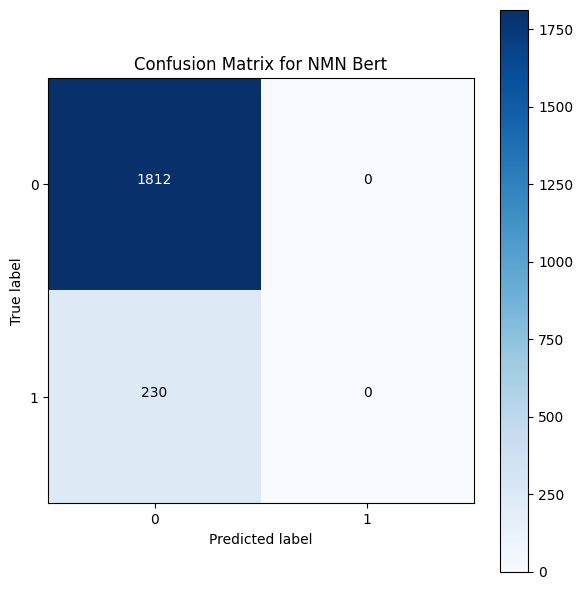

In [95]:
plt.figure(figsize=(6, 6))
cm = confusion_matrix(test_labels, nmnbert_pred)
plot_confusion_matrix(cm, title=f'Confusion Matrix for NMN Bert')

plt.show()


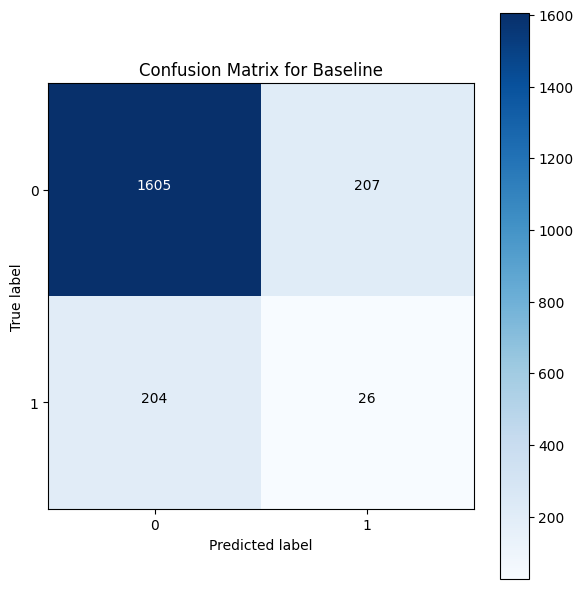

In [100]:
plt.figure(figsize=(6, 6))
cm = confusion_matrix(test_labels, baseline_pred)
plot_confusion_matrix(cm, title=f'Confusion Matrix for Baseline')

plt.show()

# Comparison Plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


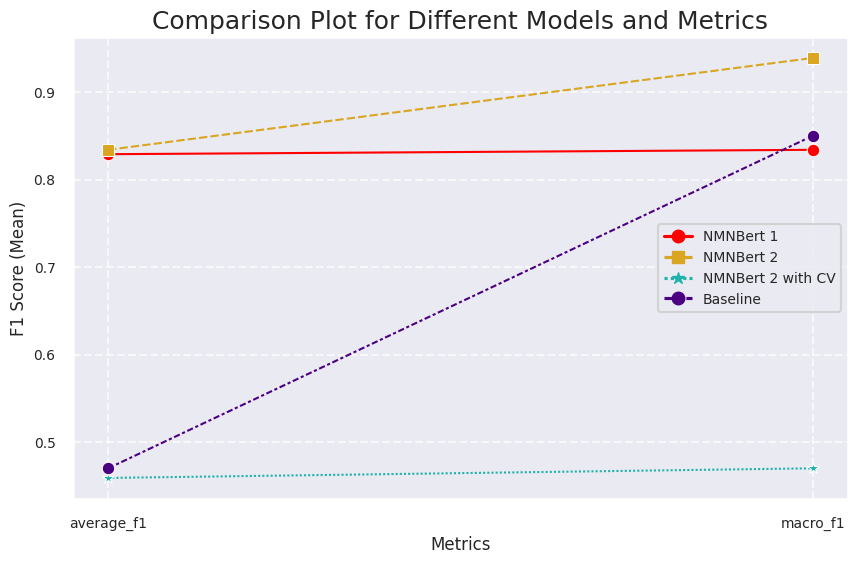

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
"""
Preparing the data for plot.
- Extracting individual features from each input dataframes

- df : pd.DataFrame
    Dataframe of prediction metrics

Plotting metric-wise and averaged F1-scores comparing all models
"""
metrics = ['average_f1', 'macro_f1']
Models= ['NMNBert 1', 'NMNBert 2', 'NMNBert 2 with CV', 'Baseline']
bert_f1= [0.829, 0.834, 0.834, 0.939]
bert_f_f1= [0.459, 0.470, 0.470, 0.850]

data = {
        'Metrics': metrics * 4,  # Repeat categories for both models
        'F1 Score': bert_f1 + bert_f_f1 ,
        'Model': [Models[0]] * len(metrics) + [Models[1]] * len(metrics) + [Models[2]] * len(metrics) + [Models[3]] * len(metrics)
    }
df = pd.DataFrame(data)

# Setting style and context
sns.set(style="darkgrid")
sns.set_context("talk")
plt.rc('axes', labelsize=12)
plt.figure(figsize=(10, 6))
markers = {Models[0]: 'o', Models[1]: 's', Models[2]: '*', Models[3]: 'o'}

# Line plot for F1 scores
line_plot = sns.lineplot(x='Metrics', y='F1 Score', hue='Model', data=df, markers=markers, style='Model', palette={Models[0]: 'red', Models[1]: 'goldenrod', Models[2]: 'lightseagreen', Models[3]: 'indigo'},linewidth=1.5)#, palette={'Uniform Model': 'blue', 'Most Frequent Model': 'orange'})


# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('F1 Score (Mean)')
plt.title('Comparison Plot for Different Models and Metrics')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)
# Show the plot
plt.legend(fontsize=10)
plt.show()

## Precision Recall Curve

In [109]:
def precision_recall(true_values, pred, name):
    plt.figure(figsize=(6, 6))

    precision, recall, _ = precision_recall_curve(true_values, pred)
    plt.plot(recall, precision, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve : {name}')
    plt.legend()
    plt.show()


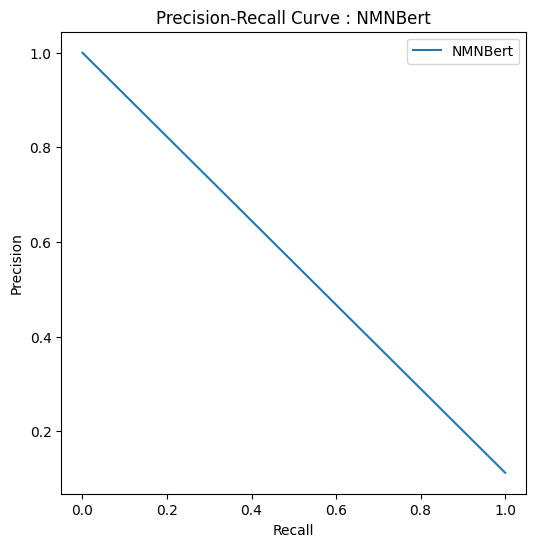

In [110]:
precision_recall(test_labels, nmnbert_pred, 'NMNBert')

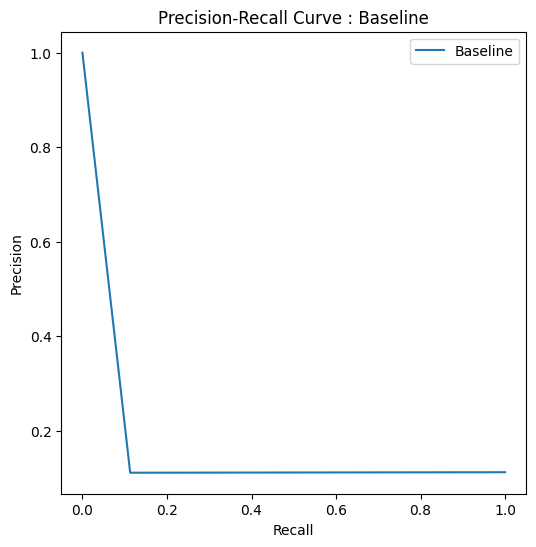

In [111]:
precision_recall(test_labels, baseline_pred, 'Baseline')

## ROC Curve

In [117]:
from sklearn.metrics import roc_curve
def roc(true_values, pred, name):
    plt.figure(figsize=(6, 6))

    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {name}')
    plt.legend(loc='lower right')
    plt.show()


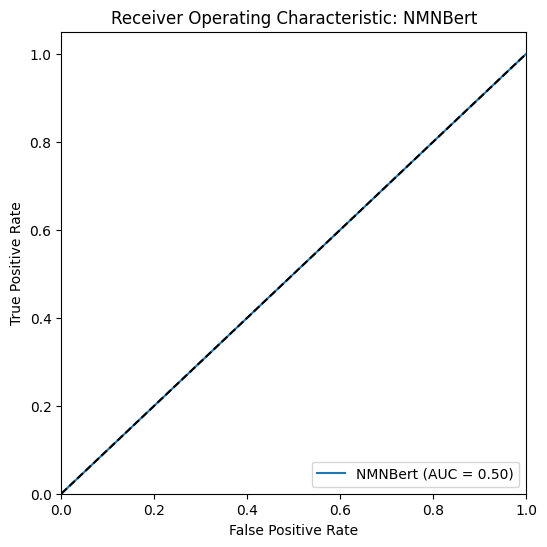

In [119]:
roc(test_labels, nmnbert_pred, 'NMNBert')

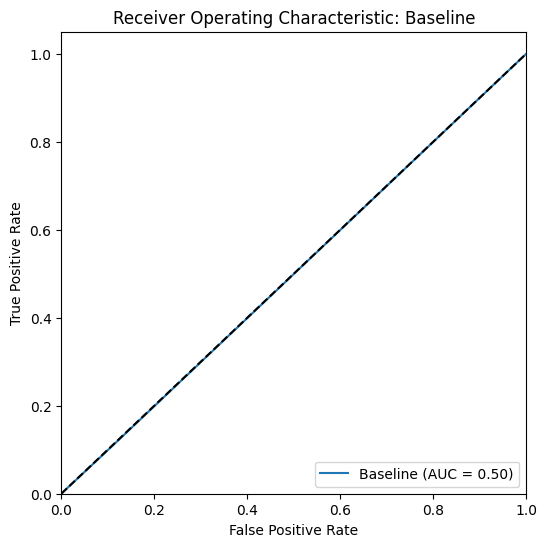

In [118]:
roc(test_labels, baseline_pred, 'Baseline')